# Display Images (Masks / Originak)

## COLOR IMAGES - ORIG / CROPPED

In [1]:
## ORIGINAL COLOR 
import cv2
import matplotlib.pyplot as plt

BASE_PATH = "/Users/saurav1/python/masters/arizona/2nd/fall/retina_ultrasound_annotation/work_dir/"

# orig = cv2.imread(BASE_PATH + "run1_2025-09-25/case2/frames_dedup/frame_000018.jpg", cv2.IMREAD_UNCHANGED)
# crop = cv2.imread(BASE_PATH + "run1_2025-09-25/case2/frames_maskcrop/frame_000018.jpg", cv2.IMREAD_UNCHANGED)
#
# print("orig shape:", orig.shape)
# print("crop shape:", crop.shape)
#
# plt.figure()
# plt.title(f"orig {orig.shape}")
# plt.imshow(orig); plt.axis('on')
#
# plt.figure();
# plt.title(f"crop {crop.shape}")
# plt.imshow(crop); plt.axis('on')

## Resized Mask and Frame

orig shape: (800, 1280, 4)
crop shape: (800, 1280)


(np.float64(-0.5), np.float64(1279.5), np.float64(799.5), np.float64(-0.5))

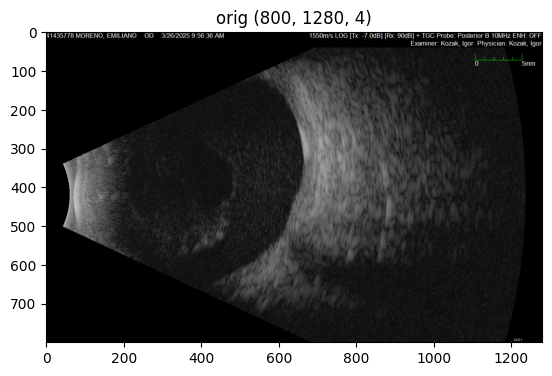

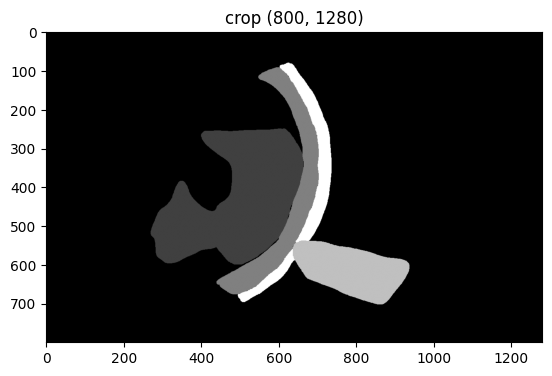

In [3]:

orig = cv2.imread(BASE_PATH + "images/Patient5/Subject 5.5.png", cv2.IMREAD_UNCHANGED)
mask = cv2.imread(BASE_PATH + "masks/Patient5/Subject 5.5.png", cv2.IMREAD_UNCHANGED)

print("orig shape:", orig.shape)
print("crop shape:", mask.shape)

plt.figure()
plt.title(f"orig {orig.shape}")
plt.imshow(orig, cmap='gray'); plt.axis('on')

plt.figure()
plt.title(f"crop {mask.shape}")
plt.imshow(mask, cmap='gray'); plt.axis('on')

## Augmentation Preview



crop shape: (512, 512)


(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

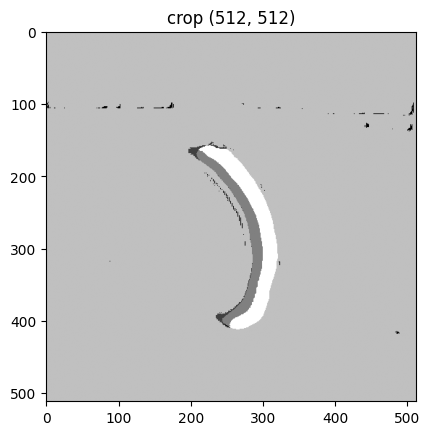

In [14]:
mask = cv2.imread(BASE_PATH + "runs/seg_unetpp/eval/pred_ids/images__Patient6__Subject 16.1.png_pred_ids.png", cv2.IMREAD_UNCHANGED)
# mask = cv2.imread(BASE_PATH + "runs/seg_unetpp/eval/pred_viz/images__Patient6__Subject 16.1.png_pred_viz.png", cv2.IMREAD_UNCHANGED)

print("crop shape:", mask.shape)

plt.figure()
plt.title(f"crop {mask.shape}")
plt.imshow(mask, cmap='gray');
plt.axis('on')


### Overlay Check for Resized Frame + mask

['/Users/saurav1/python/masters/arizona/2nd/fall/retinal_segmentation/work_dir/run1_2025-09-25/case7/frames_resized/frame_000006.jpg']
[('/Users/saurav1/python/masters/arizona/2nd/fall/retinal_segmentation/work_dir/run1_2025-09-25/case7/frames_resized/frame_000006.jpg', '/Users/saurav1/python/masters/arizona/2nd/fall/retinal_segmentation/work_dir/run1_2025-09-25/case7/masks_resized/frame_000006.png')]


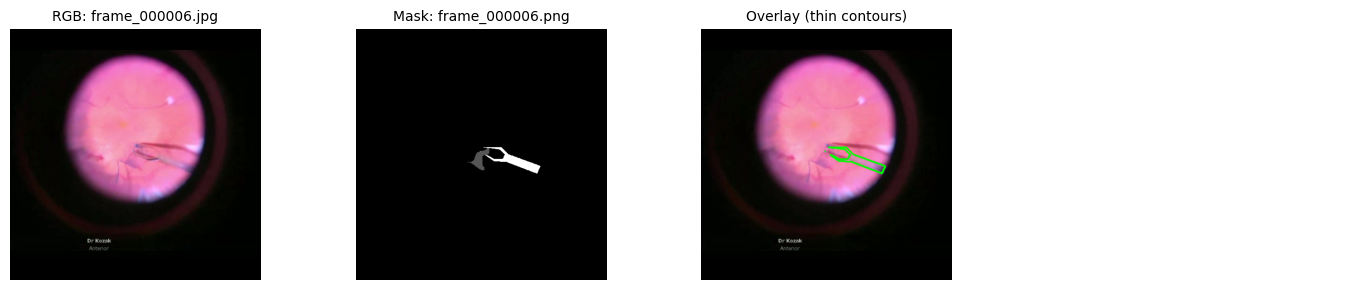

In [23]:
# --- Overlay checker for frame/mask alignment (notebook-friendly) ---
import os, random, cv2, numpy as np
import matplotlib.pyplot as plt
from glob import glob

# 1) Point this to one case folder (contains frames_* and masks_*)
CASE_ROOT = BASE_PATH + "run1_2025-09-25/case7"   # <- EDIT THIS

# 2) How many examples to visualize
N = 1

# 3) If HxW differs between frame & mask, resize mask (view-only) so we can still see it
RESIZE_MASK_FOR_VIEW_ONLY = True

FRAME_PREFS = ["frames_resized","frames_maskcrop","frames_cropped","frames_dedup","frames_raw"]
MASK_PREFS  = ["masks_resized","masks_multiclass_crop","masks_multiclass","masks_binary"]

def pick_dir(root, prefs):
    for d in prefs:
        p = os.path.join(root, d)
        if os.path.isdir(p) and any(os.scandir(p)):
            return p
    return None

def find_mask_for_image(img_path, masks_root):
    base = os.path.splitext(os.path.basename(img_path))[0]
    for ext in (".png", ".jpg", ".jpeg"):
        p = os.path.join(masks_root, base + ext)
        if os.path.isfile(p):
            return p
    # allow 'dbg_' prefix mismatches
    if base.startswith("dbg_"):
        base2 = base[4:]
        for ext in (".png", ".jpg", ".jpeg"):
            p = os.path.join(masks_root, base2 + ext)
            if os.path.isfile(p):
                return p
    return None

def overlay_contours(bgr_img, mask, color=(0,255,0), thickness=1):
    """Draw thin contours of a (possibly multi-class) mask onto image."""
    if mask.ndim == 3:
        gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    else:
        gray = mask

    # If mask has 0/255 or label IDs, just find contours on binarized version
    _, binm = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    cnts, _ = cv2.findContours(binm, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    out = bgr_img.copy()
    if cnts:
        cv2.drawContours(out, cnts, -1, color, thickness, lineType=cv2.LINE_AA)
    return out

def load_pairs(case_root):
    frames_root = pick_dir(case_root, FRAME_PREFS)
    masks_root  = pick_dir(case_root, MASK_PREFS)
    if not frames_root:
        raise FileNotFoundError(f"No frames_* dir found under {case_root}")
    if not masks_root:
        print(f"[WARN] No masks_* dir found under {case_root} — showing images only.")
    frame_paths = [os.path.join(frames_root, "frame_000006.jpg")]
    # frame_paths = sorted(glob(os.path.join(frames_root, "*.jpg")) + glob(os.path.join(frames_root, "*.png")))
    print(frame_paths)
    pairs = []
    for p_img in frame_paths:
        p_msk = find_mask_for_image(p_img, masks_root) if masks_root else None
        pairs.append((p_img, p_msk))
    return pairs

pairs = load_pairs(CASE_ROOT)
if not pairs:
    raise RuntimeError("No frames found.")
print(pairs)
samples = random.sample(pairs, min(N, len(pairs)))

# --- visualize ---
cols = 4  # RGB, Mask (gray), Overlay, (optional) zoom could be added later
rows = int(np.ceil(len(samples) / (cols/2)))  # two images per row block
plt.figure(figsize=(14, 3*rows))

idx = 1
for p_img, p_msk in samples:
    img = cv2.imread(p_img)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    msk = None
    if p_msk:
        msk = cv2.imread(p_msk, cv2.IMREAD_UNCHANGED)
        if msk is None:
            print(f"[WARN] Mask not readable: {p_msk}")

    # Check size, optionally resize mask for viewing so we can inspect visually
    warn = ""
    if msk is not None and (img.shape[0] != msk.shape[0] or img.shape[1] != msk.shape[1]):
        warn = f"[SIZE MISMATCH] img={img.shape[:2]} mask={msk.shape[:2]}"
        print(f"{os.path.basename(p_img)} -> {warn}")
        if RESIZE_MASK_FOR_VIEW_ONLY:
            interp = cv2.INTER_NEAREST  # preserve labels
            msk = cv2.resize(msk, (img.shape[1], img.shape[0]), interpolation=interp)

    # Build overlay
    overlay = img.copy()
    if msk is not None:
        bgr_for_cv = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        over_bgr = overlay_contours(bgr_for_cv, msk, color=(0,255,0), thickness=2)
        overlay  = cv2.cvtColor(over_bgr, cv2.COLOR_BGR2RGB)

    # Show RGB
    plt.subplot(rows, cols, idx); idx += 1
    plt.imshow(img); plt.axis("off")
    title = f"RGB: {os.path.basename(p_img)}"
    if warn: title += "  " + warn
    plt.title(title, fontsize=10)

    # Show mask (gray) if present
    plt.subplot(rows, cols, idx); idx += 1
    if msk is not None:
        if msk.ndim == 3:
            mgray = cv2.cvtColor(msk, cv2.COLOR_BGR2GRAY)
        else:
            mgray = msk
        plt.imshow(mgray, cmap="gray"); plt.axis("off"); plt.title(f"Mask: {os.path.basename(p_msk)}", fontsize=10)
    else:
        plt.imshow(np.zeros_like(img)); plt.axis("off"); plt.title("Mask: (missing)", fontsize=10)

    # Show overlay
    plt.subplot(rows, cols, idx); idx += 1
    plt.imshow(overlay); plt.axis("off"); plt.title("Overlay (thin contours)", fontsize=10)

    # Spacer / keep grid even
    plt.subplot(rows, cols, idx); idx += 1
    plt.axis("off")

plt.tight_layout()
plt.show()

Label histogram: {0: 259761, 1: 762, 2: 1621}


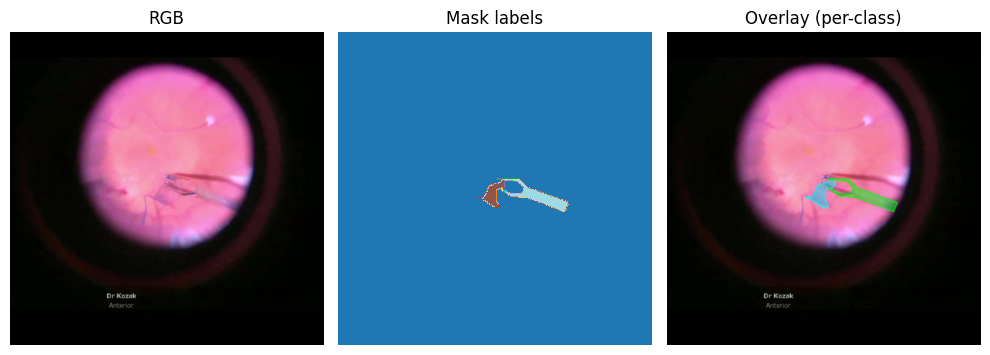

In [29]:
# Per-class overlay for ERM + instruments (robust to multiclass masks)
import os, cv2, numpy as np
import matplotlib.pyplot as plt

# ---- edit these two paths ----
FRAME_PATH = "/Users/saurav1/python/masters/arizona/2nd/fall/retinal_segmentation/work_dir/run1_2025-09-25/case7/frames_resized/frame_000006.jpg"
MASK_PATH  = "/Users/saurav1/python/masters/arizona/2nd/fall/retinal_segmentation/work_dir/run1_2025-09-25/case7/masks_resized/frame_000006.png"

# Label -> BGR color (OpenCV): 1=ERM, 2=Forceps, 3=Light tool
COLOR_MAP = {
    1: (255, 255,   0),  # ERM: cyan (BGR)
    2: (  0, 255,   0),  # Forceps: green
    3: (  0, 255, 255),  # Light tool: yellow
}
# Vis tweak: dilate thin classes for visibility (iterations per label)
DILATE_ITERS = {1: 1}  # slightly thicken ERM edges

def read_image_rgb(p):
    bgr = cv2.imread(p, cv2.IMREAD_COLOR)
    if bgr is None:
        raise FileNotFoundError(p)
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)

def read_mask_labels(p):
    """Return a single-channel label map (int) from various mask encodings."""
    m = cv2.imread(p, cv2.IMREAD_UNCHANGED)
    if m is None:
        raise FileNotFoundError(p)
    # If RGBA, drop alpha
    if m.ndim == 3 and m.shape[2] == 4:
        m = m[:, :, :3]
    # Convert any 3-channel mask to gray
    if m.ndim == 3:
        m = cv2.cvtColor(m, cv2.COLOR_BGR2GRAY)

    # Many exports use values like {0,1,2,3} or {0,50,100,150,255}.
    # If the number of unique levels is small, map them to 0..K
    uniq = np.unique(m).tolist()
    if len(uniq) <= 16:  # treat as labeled levels
        uniq_sorted = sorted(int(v) for v in uniq)
        mapping = {v:i for i,v in enumerate(uniq_sorted)}  # background becomes 0
        lab = np.vectorize(mapping.get)(m).astype(np.uint8)
    else:
        # Fallback: assume already labeled
        lab = m.astype(np.uint8)
    return lab

def overlay_labels(rgb, labels, alpha=0.45):
    """
    Alpha-blend colored regions for each class and draw contours.
    - rgb: HxWx3 (uint8, RGB)
    - labels: HxW (uint8 ints: 0=bg, 1=ERM, 2=Forceps, 3=Light tool, ...)
    """
    base_bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR).copy()

    for lid, bgr in COLOR_MAP.items():
        # 2-D mask for the class
        m = (labels == lid).astype(np.uint8)
        if m.sum() == 0:
            continue

        # optional visibility dilation (e.g., slightly thicken ERM)
        it = int(DILATE_ITERS.get(lid, 0))
        if it > 0:
            m = cv2.dilate(m, np.ones((3, 3), np.uint8), iterations=it)

        # prepare a solid color image and blend only where mask==1
        color = np.zeros_like(base_bgr, dtype=np.uint8)
        color[:, :, 0] = bgr[0]
        color[:, :, 1] = bgr[1]
        color[:, :, 2] = bgr[2]

        # ----- FIX: use a 2-D boolean mask to index (not HxWx1) -----
        m_bool = m.astype(bool)
        blended = base_bgr.copy()
        blended[m_bool] = (
            alpha * color[m_bool] + (1.0 - alpha) * base_bgr[m_bool]
        ).astype(np.uint8)
        base_bgr = blended

        # crisp contour on top
        cnts, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if cnts:
            cv2.drawContours(base_bgr, cnts, -1, (int(bgr[0]), int(bgr[1]), int(bgr[2])), 1, cv2.LINE_AA)

    return cv2.cvtColor(base_bgr, cv2.COLOR_BGR2RGB)

# ---- run once for a pair ----
rgb = read_image_rgb(FRAME_PATH)
lab = read_mask_labels(MASK_PATH)

# SIZE CHECK (don’t resize masks for training; here we only fix view if needed)
if (rgb.shape[0], rgb.shape[1]) != lab.shape[:2]:
    print(f"[WARN] Size mismatch: img={rgb.shape[:2]} mask={lab.shape[:2]} (view-only resize applied)")
    lab = cv2.resize(lab, (rgb.shape[1], rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

# Debug: show what labels are present
vals, counts = np.unique(lab, return_counts=True)
print("Label histogram:", dict(zip(vals.tolist(), counts.tolist())))
# Tip: if '1' (ERM) is missing, that frame likely has no ERM annotation *or*
# it was lost during an earlier downscale with a non-NEAREST interpolation.

overlay = overlay_labels(rgb, lab, alpha=0.45)

plt.figure(figsize=(10,5))
plt.subplot(1,3,1); plt.imshow(rgb);     plt.axis("off"); plt.title("RGB")
plt.subplot(1,3,2); plt.imshow(lab, cmap="tab20"); plt.axis("off"); plt.title("Mask labels")
plt.subplot(1,3,3); plt.imshow(overlay); plt.axis("off"); plt.title("Overlay (per-class)")
plt.tight_layout(); plt.show()

In [30]:
import cv2, numpy as np

def overlay_contour(bgr, mask, color=(0,255,0), thick=2):
    if mask.ndim == 3: mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    binv = (mask > 0).astype(np.uint8)*255
    cnts, _ = cv2.findContours(binv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    out = bgr.copy()
    cv2.drawContours(out, cnts, -1, color, thick, lineType=cv2.LINE_AA)
    return out

# point to a pair you see in the preview
img_p = "/Users/saurav1/python/masters/arizona/2nd/fall/retinal_segmentation/work_dir/run1_2025-09-25/case7/frames_resized/frame_000006.jpg"
msk_p  = "/Users/saurav1/python/masters/arizona/2nd/fall/retinal_segmentation/work_dir/run1_2025-09-25/case7/masks_resized/frame_000006.png"

img = cv2.imread(img_p)
msk = cv2.imread(msk_p, cv2.IMREAD_UNCHANGED)
ovl = overlay_contour(img, msk)
cv2.imwrite("tmp_overlay.png", ovl)
print("wrote tmp_overlay.png")

wrote tmp_overlay.png
